Traffic Light Detector Node CNN Experiments
======

These is the R&N notebook for the traffic light detector node
The network is trained on 64x64 samples in 4 classes (nothing, red, green, yellow)

Henrik Tünnermann

In [1]:
import glob
import numpy as np
import cv2

In [2]:
#need to set the data path
nothing = glob.glob("/home/henrik/Downloads/tlmodel/tl_data/nothing/*.jpg")
redlights = glob.glob("/home/henrik/Downloads/tlmodel/tl_data/redlights/*.jpg")

greenlights = glob.glob("/home/henrik/Downloads/tlmodel/tl_data/greenlights/*.jpg")
yellowlights = glob.glob("/home/henrik/Downloads/tlmodel/tl_data/yellowlights/*.jpg")


Y = np.concatenate([np.ones(len(redlights)), np.zeros(len(nothing))-1])
Y = np.concatenate([np.array([[1,0,0,0]]*len(nothing)), 
                    np.array([[0,1,0,0]]*len(redlights)),
                    np.array([[0,0,1,0]]*len(greenlights)),
                    np.array([[0,0,0,1]]*len(yellowlights))
                   ])

# Read X Vector
X = []
for name in nothing:    
    data = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    if(data.shape[0]!=64):
        print("err %s", name)
    X.append(data)
    
for name in redlights:    
    X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
    
for name in greenlights:    
    X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))
    
for name in yellowlights:    
    X.append(cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB))

X = np.array(X)

Populating the interactive namespace from numpy and matplotlib


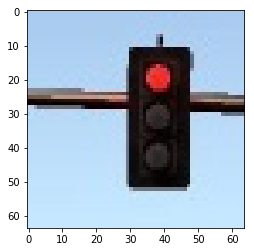

In [3]:
%pylab inline 
imshow(X[1255])

### After loading I do the usual pre-processing

I do not use a validation split, but I have to validate that the model works well in localization independently anyway.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

('X_train shape:', (2030, 64, 64, 3))
(2030, 'train samples')
(226, 'test samples')


In [5]:
import tensorflow as tf
import numpy as np

def model(data, train):
    norm = data/127.5 - 1
    c1 = tf.layers.conv2d(norm, 16, 3, strides=(1, 1), padding='SAME',
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.001), activation=tf.nn.relu)
    c2 = tf.layers.conv2d(c1, 16, 3, strides=(1, 1), padding='SAME',
                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.001), activation=tf.nn.relu)
    p = tf.layers.max_pooling2d(c2, 8, strides=(8,8), padding='SAME')
    
    drop1 = tf.layers.dropout(p,rate=0.25,training=train)
    
    c3 = tf.layers.conv2d(drop1, 128, 8, strides=(1, 1), padding='VALID',
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.001), activation=tf.nn.relu)
    
    drop2 = tf.layers.dropout(c3,rate=0.50,training=train)
    c4 = tf.layers.conv2d(drop2, 4, 1, strides=(1, 1), padding='VALID',
        kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
    sm = tf.nn.softmax(c4, name="output")
    return c4,sm
    
def loss(data, correct_label):    
    logits = tf.reshape(data,(-1,4),name='logits')
    labels = tf.reshape(correct_label,(-1,4),name='lables')
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    return loss,train_op,tf_accuracy



#need to set the test data path
testdata = (cv2.cvtColor(cv2.imread("/home/henrik/Downloads/tlmodel/testimagesreal/just00151.jpg"), cv2.COLOR_BGR2RGB))

batches = (int(np.ceil(X_train.shape[0]/64.)))


with tf.Session() as sess:
    
    
    tf_data = tf.placeholder(tf.float32, shape=(None, None, None, 3), name="image_input")
    tf_labels = tf.placeholder(tf.float32, shape=(None),name="labels_input")
    tf_train = tf.placeholder(tf.bool,name="train_input")
    
    modelout,sm = model(tf_data, tf_train)
    l,train_op, tf_accuracy = loss(modelout, tf_labels)

    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(300):
        for batch_i in range(batches):
            train_loss, _, accuracy = sess.run([l, train_op, tf_accuracy],
                        feed_dict={tf_data: X_train[batch_i*64:batch_i*64+64], 
                                   tf_labels: Y_train[batch_i*64:batch_i*64+64], 
                                   tf_train: True})
            # Display the loss after every tenth batch
            

        # Display the loss after the epoch
       
        print('Epoch {:>3} Batch {:>2}   Training loss = {:.3f} Acc:{:.3f}'.format(epoch_i+1, batch_i+1, train_loss, accuracy))
        
        train_loss, accuracy = sess.run([l, tf_accuracy],feed_dict={tf_data: X_test, tf_labels: Y_test, 
                                   tf_train: False})
        print('Test: Epoch {:>3} Batch {:>2}   Training loss = {:.3f} Acc:{:.3f}'.format(epoch_i+1, batch_i+1, train_loss, accuracy))
        
        
    
    saver = tf.train.Saver()
    saver.save(sess, "tldetector-rev.tf",global_step=1000)

    
        
    

    

Epoch   1 Batch 32   Training loss = 1.292 Acc:0.435
Test: Epoch   1 Batch 32   Training loss = 1.247 Acc:0.522
Epoch   2 Batch 32   Training loss = 1.279 Acc:0.435
Test: Epoch   2 Batch 32   Training loss = 1.208 Acc:0.522
Epoch   3 Batch 32   Training loss = 1.272 Acc:0.413
Test: Epoch   3 Batch 32   Training loss = 1.176 Acc:0.518
Epoch   4 Batch 32   Training loss = 1.250 Acc:0.348
Test: Epoch   4 Batch 32   Training loss = 1.133 Acc:0.535
Epoch   5 Batch 32   Training loss = 1.222 Acc:0.413
Test: Epoch   5 Batch 32   Training loss = 1.093 Acc:0.522
Epoch   6 Batch 32   Training loss = 1.161 Acc:0.370
Test: Epoch   6 Batch 32   Training loss = 1.071 Acc:0.540
Epoch   7 Batch 32   Training loss = 1.152 Acc:0.391
Test: Epoch   7 Batch 32   Training loss = 1.040 Acc:0.558
Epoch   8 Batch 32   Training loss = 1.075 Acc:0.500
Test: Epoch   8 Batch 32   Training loss = 0.990 Acc:0.562
Epoch   9 Batch 32   Training loss = 1.027 Acc:0.478
Test: Epoch   9 Batch 32   Training loss = 0.962 Ac

# Load model tests

Populating the interactive namespace from numpy and matplotlib
INFO:tensorflow:Restoring parameters from ./tldetector-rev.tf-1000
('Nothing:', 514)
('Red:', 2)
('Green:', 0)
('Yellow:', 0)


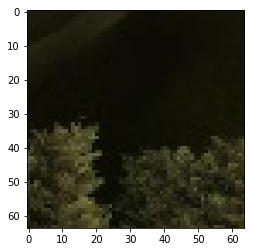

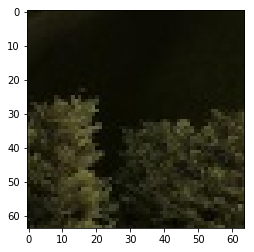

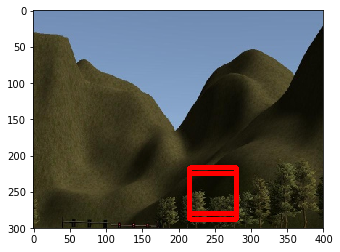

In [17]:
import tensorflow as tf
import cv2
%pylab inline



with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('tldetector-rev.tf-1000.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    
    

    tf_data = graph.get_tensor_by_name("image_input:0")
    tf_train = graph.get_tensor_by_name("train_input:0")
    tf_label = graph.get_tensor_by_name("labels_input:0")    
    sm = graph.get_tensor_by_name("output:0")
    
    #green
    testdata = (cv2.cvtColor(cv2.imread("/home/henrik/Downloads/tlmodel/testimages/00301.jpg"), cv2.COLOR_BGR2RGB))
    #red
    #testdata = (cv2.cvtColor(cv2.imread("/home/henrik/Downloads/tlmodel/testimages/00372.jpg"), cv2.COLOR_BGR2RGB))
    #on site yellow
    #testdata = (cv2.cvtColor(cv2.imread("/home/henrik/Downloads/tlmodel/testimagesreal/just00720.jpg"), cv2.COLOR_BGR2RGB))
    #testdata = (cv2.cvtColor(cv2.imread("/home/henrik/Downloads/tlmodel/testimagesreal/lopp00801.jpg"), cv2.COLOR_BGR2RGB))

    
    img = sess.run([sm], feed_dict={tf_data: testdata.reshape([1,300, 400, 3]), tf_train: False})
    
    threshold = 0.99
    
    img = np.array(img)
    print("Nothing:",np.sum(img[0,0,:,:,0]>threshold))
    print("Red:",np.sum(img[0,0,:,:,1]>threshold))
    print("Green:",np.sum(img[0,0,:,:,2]>threshold))
    print("Yellow:",np.sum(img[0,0,:,:,3]>threshold))
    
    
    #imshow(testdata)
    #show()
    #i = img[0,0,:,:,1]
    
    
    #imshow(i,vmin=0, vmax=1)
    #colorbar()
    #show()

    def augment(raw,boolean, color):
        xx, yy = np.meshgrid(np.arange(img.shape[3]),np.arange(img.shape[2]))

        x = (xx[boolean])
        y = (yy[boolean])
        count = 0
        

        for i,j in zip(x,y):
            imshow(original[j*8:j*8+64, i*8:i*8+64])
            show()
            #print(color)
            cv2.imwrite("abq%03d.jpg"%count,cv2.cvtColor(original[j*8:j*8+64, i*8:i*8+64],cv2.COLOR_BGR2RGB))
            count = count+1
            cv2.rectangle(testdata, (i*8,j*8), (i*8+64,j*8+64), color, 5)

            
    original = testdata.copy()
    augment(testdata,img[0,0,:,:,1]>threshold,(255,0,0))
    augment(testdata,img[0,0,:,:,2]>threshold,(0,255,0))
    augment(testdata,img[0,0,:,:,3]>threshold,(255,255,0))
    
    imshow(testdata)
    show()


    

hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
hi
(60, 64, 3)
